# Assignment 3
## Image Alignment

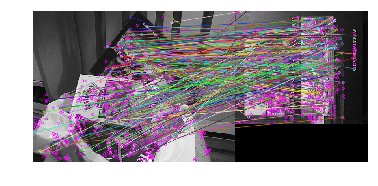

Transform Matrix:
 [[   1.11277622   -1.229        41.34514545]
 [   1.21522473    1.04340866 -326.52685589]]


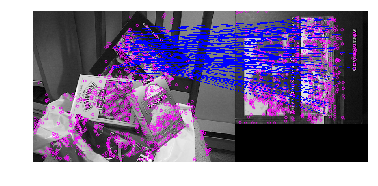

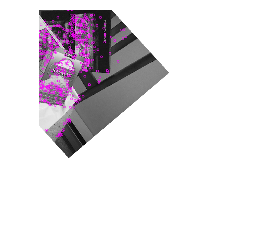

In [5]:
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt


def ransac(T):
    trans_param = None
    maxInliers = []
    count = 0
    while count < 100:
        try:
            p = []
            A = []
            b = []
            inliers = []
            for j in range(3):
                p.append(T[random.randrange(0, len(T))])
            for j in range(3):
                p1 = [p[j][0], p[j][1]]
                p2 = [p[j][2], p[j][3]]
                A.append([p1[0], p1[1], 1, 0, 0, 0])
                A.append([0, 0, 0, p1[0], p1[1], 1])
                b.append(p2[0])
                b.append(p2[1])
            A = np.array(A)
            #print(A)
            b = np.array(b)
            #print(b)
            x = np.linalg.solve(A, b)
            #print(x)
            x1 = x.tolist()
            x1.append(0)
            x1.append(0)
            x1.append(1)
            x1 = np.array(x1)
            h = np.reshape(x1, (3, 3))
            for j in range(len(T)):
                c = np.transpose(np.matrix([T[j][0], T[j][1], 1]))
                gt = np.transpose(np.matrix([T[j][2], T[j][3], 1]))
                est = np.dot(h, c)
                est = (1 / est.item(2)) * est
                loss = np.linalg.norm(est - gt)
                if loss < 10:
                    inliers.append(T[j])
            if len(inliers) > len(maxInliers):
                maxInliers = inliers
                #print(len(maxInliers))
                trans_param = np.reshape(x, (2, 3))
            count += 1
        except:
            continue

    for i in range(int(len(maxInliers)/3)):
        A = []
        b = []
        inliers = []
        try:
            for j in range(3):
                p = maxInliers[3*i+j]
                p1 = [p[0], p[1]]
                p2 = [p[2], p[3]]
                A.append([p1[0], p1[1], 1, 0, 0, 0])
                A.append([0, 0, 0, p1[0], p1[1], 1])
                b.append(p2[0])
                b.append(p2[1])
            A = np.array(A)
            b = np.array(b)
            x = np.linalg.solve(A, b)
            x1 = x.tolist()
            x1.append(0)
            x1.append(0)
            x1.append(1)
            x1 = np.array(x1)
            h = np.reshape(x1, (3, 3))
            for j in range(len(T)):
                c = np.transpose(np.matrix([T[j][0], T[j][1], 1]))
                gt = np.transpose(np.matrix([T[j][2], T[j][3], 1]))
                est = np.dot(h, c)
                est = (1 / est.item(2)) * est
                #print(est)
                loss = np.linalg.norm(est - gt)
                if loss < 10:
                    inliers.append(T[j])
            if len(inliers) > len(maxInliers):
                maxInliers = inliers
                trans_param = np.reshape(x, (2, 3))
        except:
            continue
    return maxInliers, trans_param


def drawMatches(img1, img2, inliers):
    row1, col1 = img1.shape[:2]
    #print(row1, col1)
    row2, col2 = img2.shape[:2]
    #print(row2, col2)
    output = np.zeros((max(row1,row2), col1+col2,3),dtype='uint8')
    output[:row1, :col1, :] = img1
    output[:row2, col1:col1+col2, :] = img2
    for inlier in inliers:
        #print(inlier[0])
        #print(int(inlier[0]))
        cv2.line(output,(int(inlier[0]), int(inlier[1])), (int(inlier[2]+col1),int(inlier[3])),(0,0,255),1)
    return output


sift = cv2.xfeatures2d.SIFT_create()
img_1 = cv2.imread("scene.pgm")
img_2 = cv2.imread("book.pgm")
kp_1, des_1 = sift.detectAndCompute(img_1, None)
kp_2, des_2 = sift.detectAndCompute(img_2, None)

img_1 = cv2.drawKeypoints(img_1, kp_1, img_1, color=(255, 0, 255))
img_2 = cv2.drawKeypoints(img_2, kp_2, img_2, color=(255, 0, 255))

# cv2.imwrite('img1_keypoints.jpg',img_1)
# cv2.imwrite('img2_keypoints.jpg',img_2)

bf = cv2.BFMatcher()
matches = bf.knnMatch(des_1, des_2, k=2)
# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.9 * n.distance:
        good.append([m])
# cv.drawMatchesKnn expects list of lists as matches.
img3 = cv2.drawMatchesKnn(img_1, kp_1, img_2, kp_2, good, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3)
plt.axis('off')
plt.show()
pairs = []
for m in good:
    pairs.append([kp_1[m[0].queryIdx].pt[0], kp_1[m[0].queryIdx].pt[1], kp_2[m[0].trainIdx].pt[0], kp_2[m[0].trainIdx].pt[1]])

inlier_set, trans = ransac(pairs)
print("Transform Matrix:\n",trans)

#M = np.matrix([[trans.item(0),trans.item(1),trans.item(4)],[trans.item(2),trans.item(3),trans.item(5)]])
out = drawMatches(img_1, img_2, inlier_set)
plt.imshow(out)
plt.axis('off')
plt.show()
transfered = cv2.warpAffine(img_1, trans, (1024,1024), borderValue=(255, 255, 255))
plt.imshow(transfered)
plt.axis('off')
plt.show()

## Estimating the Camera Parameters

In [6]:
import cv2
import numpy as np
from scipy import linalg
img_points = open("image.txt")
world_points = open("world.txt")
lines = img_points.readlines()
img_xs = lines[0].split('\n')[0].split('  ')[1:]
img_ys = lines[1].split('\n')[0].split('  ')[1:]
lines = world_points.readlines()
world_xs = lines[0].split('\n')[0].split('  ')[1:]
world_ys = lines[1].split('\n')[0].split('  ')[1:]
world_zs = lines[2].split('\n')[0].split('  ')[1:]

A = []
X = []
Y = []
Z = []
cor = [1]*10
for i in range(10):
    X.append(float(world_xs[i]))
    Y.append(float(world_ys[i]))
    Z.append(float(world_zs[i]))
    A.append([float(world_xs[i]), float(world_ys[i]), float(world_zs[i]), 1, 0, 0, 0, 0, -1 * float(img_xs[i]) * float(world_xs[i]), -1 * float(img_xs[i]) * float(world_ys[i]), -1 * float(img_xs[i]) * float(world_zs[i]), -1 * float(img_xs[i])])
    A.append([0, 0, 0, 0, float(world_xs[i]), float(world_ys[i]),  float(world_zs[i]), 1, -1 * float(img_ys[i]) * float(world_xs[i]), -1 * float(img_ys[i]) * float(world_ys[i]), -1 * float(img_ys[i]) * float(world_zs[i]), -1 * float(img_ys[i])])
A = np.matrix(A)
u, s, v = np.linalg.svd(A)
h = np.reshape(v[11], (3, 4))
#print(h)
W = []
W.append(X)
W.append(Y)
W.append(Z)
W.append(cor)
W = np.matrix(W)
proj_img = np.dot(h,W)
print("Matrix P:\n",h)
#print(proj_img)
x = []
y = []
for i in range(10):
    s = 1/proj_img[2].item(i)
    x.append(proj_img[0].item(i)*s)
    y.append(proj_img[1].item(i)*s)
with open("result.txt","w") as f:
    for i in range(10):
        f.writelines('  '+str(x[i]))
    f.writelines('\n')
    for i in range(10):
        f.writelines('  '+str(y[i]))

K,R = linalg.rq(h[:,:3])
#print(K.size)
#print(R.size)

# make diagonal of K positive
T = np.diag(np.sign(np.diag(K)))
if linalg.det(T) < 0:
    T[1,1] *= -1
#print(T.size)

K = np.dot(K,T)
R = np.dot(T,R) # T is its own inverse
t = np.dot(linalg.inv(K),h[:,3])
#print(K)
#print(R)
#print(t)
c = -np.dot(R.T, t)
print("Aproach 2:\n",c)
u, s, v = np.linalg.svd(h)
v = (1/(v[3].item(3)))*v
print("Aproach 1:\n",v[3])

Matrix P:
 [[ 1.27000127e-01  2.54000254e-01  3.81000381e-01  5.08000508e-01]
 [ 5.08000508e-01  3.81000381e-01  2.54000254e-01  1.27000127e-01]
 [ 1.27000127e-01  1.11022302e-16  1.27000127e-01 -5.55111512e-17]]
Aproach 2:
 [[ 1.]
 [-1.]
 [-1.]]
Aproach 1:
 [[ 1. -1. -1.  1.]]


## Structure from Motion

T0:
 5.495603971894525e-17 -7.031412489292659e-18
M0:
 [[-3.88158383  4.736574   -6.01312498]
 [-3.13055492  3.51140571 -5.1782021 ]]
First 10 points:
 [[ 0.01785283  0.06031902  0.00399414]
 [ 0.04983441 -0.04789194  0.0097195 ]
 [-0.04591506 -0.01010731 -0.02792778]
 [ 0.0512407  -0.04256735  0.02876416]
 [-0.01059037 -0.00094359  0.08101904]
 [-0.04979149 -0.02411537  0.01307363]
 [ 0.04841581 -0.03627917  0.02120794]
 [-0.01666144 -0.01649072  0.0926918 ]
 [-0.03317388 -0.03437912 -0.0022843 ]
 [-0.0357204  -0.02265548  0.02091869]]


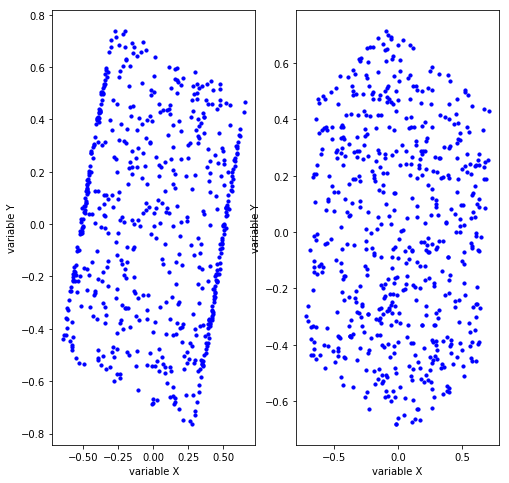

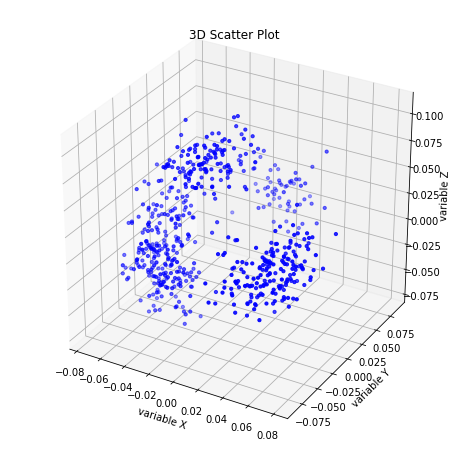

In [7]:
from mpl_toolkits.mplot3d import Axes3D
import scipy.io as sio
from matplotlib import pyplot as plt
import numpy as np
image_points = sio.loadmat("sfm_points.mat")['image_points']
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(121)
ax1 = fig.add_subplot(122)

ax.scatter(image_points[0, :, 1], image_points[1, :, 1],
           marker='.', color='blue', s=40, label='class 1')
ax.set_xlabel('variable X')
ax.set_ylabel('variable Y')

ax1.scatter(image_points[0, :, 5], image_points[1, :, 5],
           marker='.', color='blue', s=40, label='class 1')
ax1.set_xlabel('variable X')
ax1.set_ylabel('variable Y')


for i in range(10):
    centroid_x = sum(image_points[0, :, i])/600
    centroid_y = sum(image_points[1, :, i])/600
    if i == 0:
        print("T0:\n",centroid_x,centroid_y)
    for j in range(600):
        image_points[0, j, i] -= centroid_x
        image_points[1, j, i] -= centroid_y

image_points = np.reshape(image_points,(20,600))


u, s, v = np.linalg.svd(image_points)
#print(len(u),u.size)
#print(s)
#print(len(v),v.size)
s = np.diag(s[0:3])
M = np.dot(u[:,:3],s)
print("M0:\n",M[:2,:])
v = v.T
world_points = v[:,:3]
print("First 10 points:\n",world_points[:10,:])

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
#print((world_points[:, 0]))

ax.scatter(world_points[:, 0], world_points[:, 1], world_points[:, 2],

           marker='.', color='blue', s=40, label='class 1')

ax.set_xlabel('variable X')
ax.set_ylabel('variable Y')
ax.set_zlabel('variable Z')

plt.title('3D Scatter Plot')

plt.show()